In [2]:
!nvidia-smi

Sun May 12 15:32:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 9.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyl

In [4]:
!pip install imgkit
!pip install easyocr
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 39.3 MB/s eta 0:00:00


In [5]:
from transformers import LayoutLMv3FeatureExtractor, LayoutLMv3TokenizerFast, LayoutLMv3Processor, LayoutLMv3ForSequenceClassification
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from sklearn.model_selection import train_test_split
import imgkit
import easyocr
import torchvision.transforms as T
from pathlib import Path
import matplotlib.pyplot as plt
import os
import cv2
from typing import List
import json
from torchmetrics import Accuracy
from huggingface_hub import notebook_login
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

In [6]:
!gdown 1tMZXonmajLPK9zhZ2dt-CdzRTs5YfHy0

Downloading...
From: https://drive.google.com/uc?id=1tMZXonmajLPK9zhZ2dt-CdzRTs5YfHy0
To: /content/financial-documents.zip
100% 3.10M/3.10M [00:00<00:00, 248MB/s]


In [7]:
!unzip -q financial-documents.zip
!mv "TableClassifierQuaterlyWithNotes" "financial_docs"

In [8]:
for dir in Path("financial_docs").glob("*"):
    dir.rename(str(dir).lower().replace(" ", "_"))

In [9]:
for dir in Path("financial_docs").glob("*"):
    image_dir = Path(f"images/{dir.name}")
    image_dir.mkdir(exist_ok=True, parents=True)

def convert_html_to_image(file_path: Path, images_dir: Path, scale: float = 1.0) -> Path:
    file_name = file_path.with_suffix(".jpg").name
    save_path = images_dir / file_path.parent.name / f"{file_name}"
    imgkit.from_file(str(file_path), save_path, options={'quiet': '', 'format': 'jpeg', 'enable-local-file-access': ""})

    image = Image.open(save_path)
    width, height = image.size
    image = image.resize((int(width * scale), int(height * scale)))
    image.save(str(save_path))

    return save_path

In [10]:
!apt-get install -y wkhtmltopdf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  avahi-daemon bind9-host bind9-libs geoclue-2.0 glib-networking glib-networking-common
  glib-networking-services gsettings-desktop-schemas iio-sensor-proxy libavahi-core7 libavahi-glib1
  libdaemon0 libevdev2 libfontenc1 libgudev-1.0-0 libhyphen0 libinput-bin libinput10
  libjson-glib-1.0-0 libjson-glib-1.0-common liblmdb0 libmaxminddb0 libmbim-glib4 libmbim-proxy
  libmd4c0 libmm-glib0 libmtdev1 libnl-genl-3-200 libnotify4 libnss-mdns libproxy1v5 libqmi-glib5
  libqmi-proxy libqt5core5a libqt5dbus5 libqt5gui5 libqt5network5 libqt5positioning5
  libqt5printsupport5 libqt5qml5 libqt5qmlmodels5 libqt5quick5 libqt5sensors5 libqt5svg5
  libqt5webchannel5 libqt5webkit5 libqt5widgets5 libsoup2.4-1 libsoup2.4-common libudev1
  libwacom-bin libwacom-common libwacom9 libwoff1 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libx

In [11]:
document_paths = list(Path("financial_docs").glob("*/*"))

for doc_path in tqdm(document_paths):
    convert_html_to_image(doc_path, Path("images"), scale=0.8)

100%|██████████| 2573/2573 [15:28<00:00,  2.77it/s]


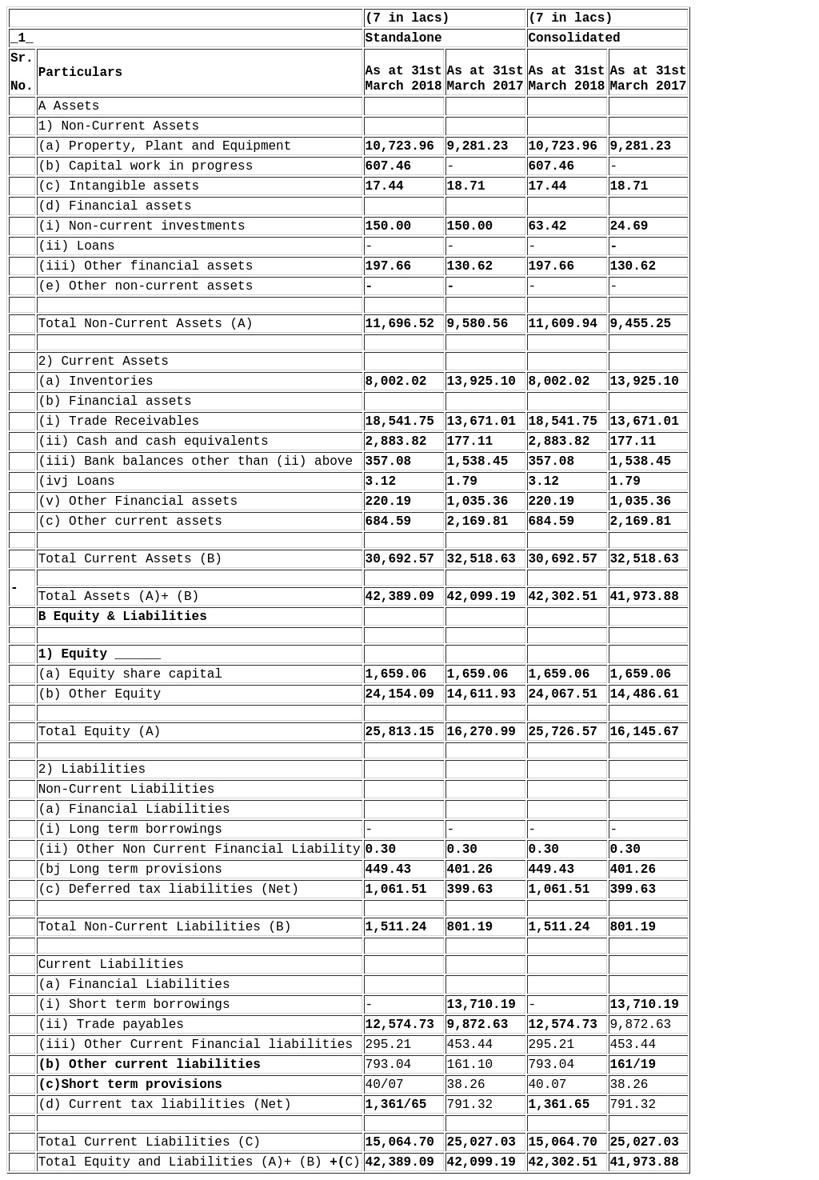

In [18]:
image_paths = sorted(list(Path("images").glob("*/*.jpg")))

image = Image.open(image_paths[0]).convert("RGB")
width, height = image.size
image

In [20]:
read_data = easyocr.Reader(['en','fr','nl'])

In [21]:
%%time
image_path = image_paths[0]
ocr_result = read_data.readtext(str(image_path))

def create_bounding_box(bbox_data):
    xs = []
    ys = []
    for x, y in bbox_data:
        xs.append(x)
        ys.append(y)

    left = int(min(xs))
    top = int(min(ys))
    right = int(max(xs))
    bottom = int(max(ys))

    return [left, top, right, bottom]

CPU times: user 3.42 s, sys: 118 ms, total: 3.54 s
Wall time: 4.28 s


In [24]:
font_path = Path(cv2.__path__[0]) / "qt/fonts/DejaVuSansCondensed.ttf"
print(font_path.exists())
font = ImageFont.truetype(str(font_path), size=12)

True


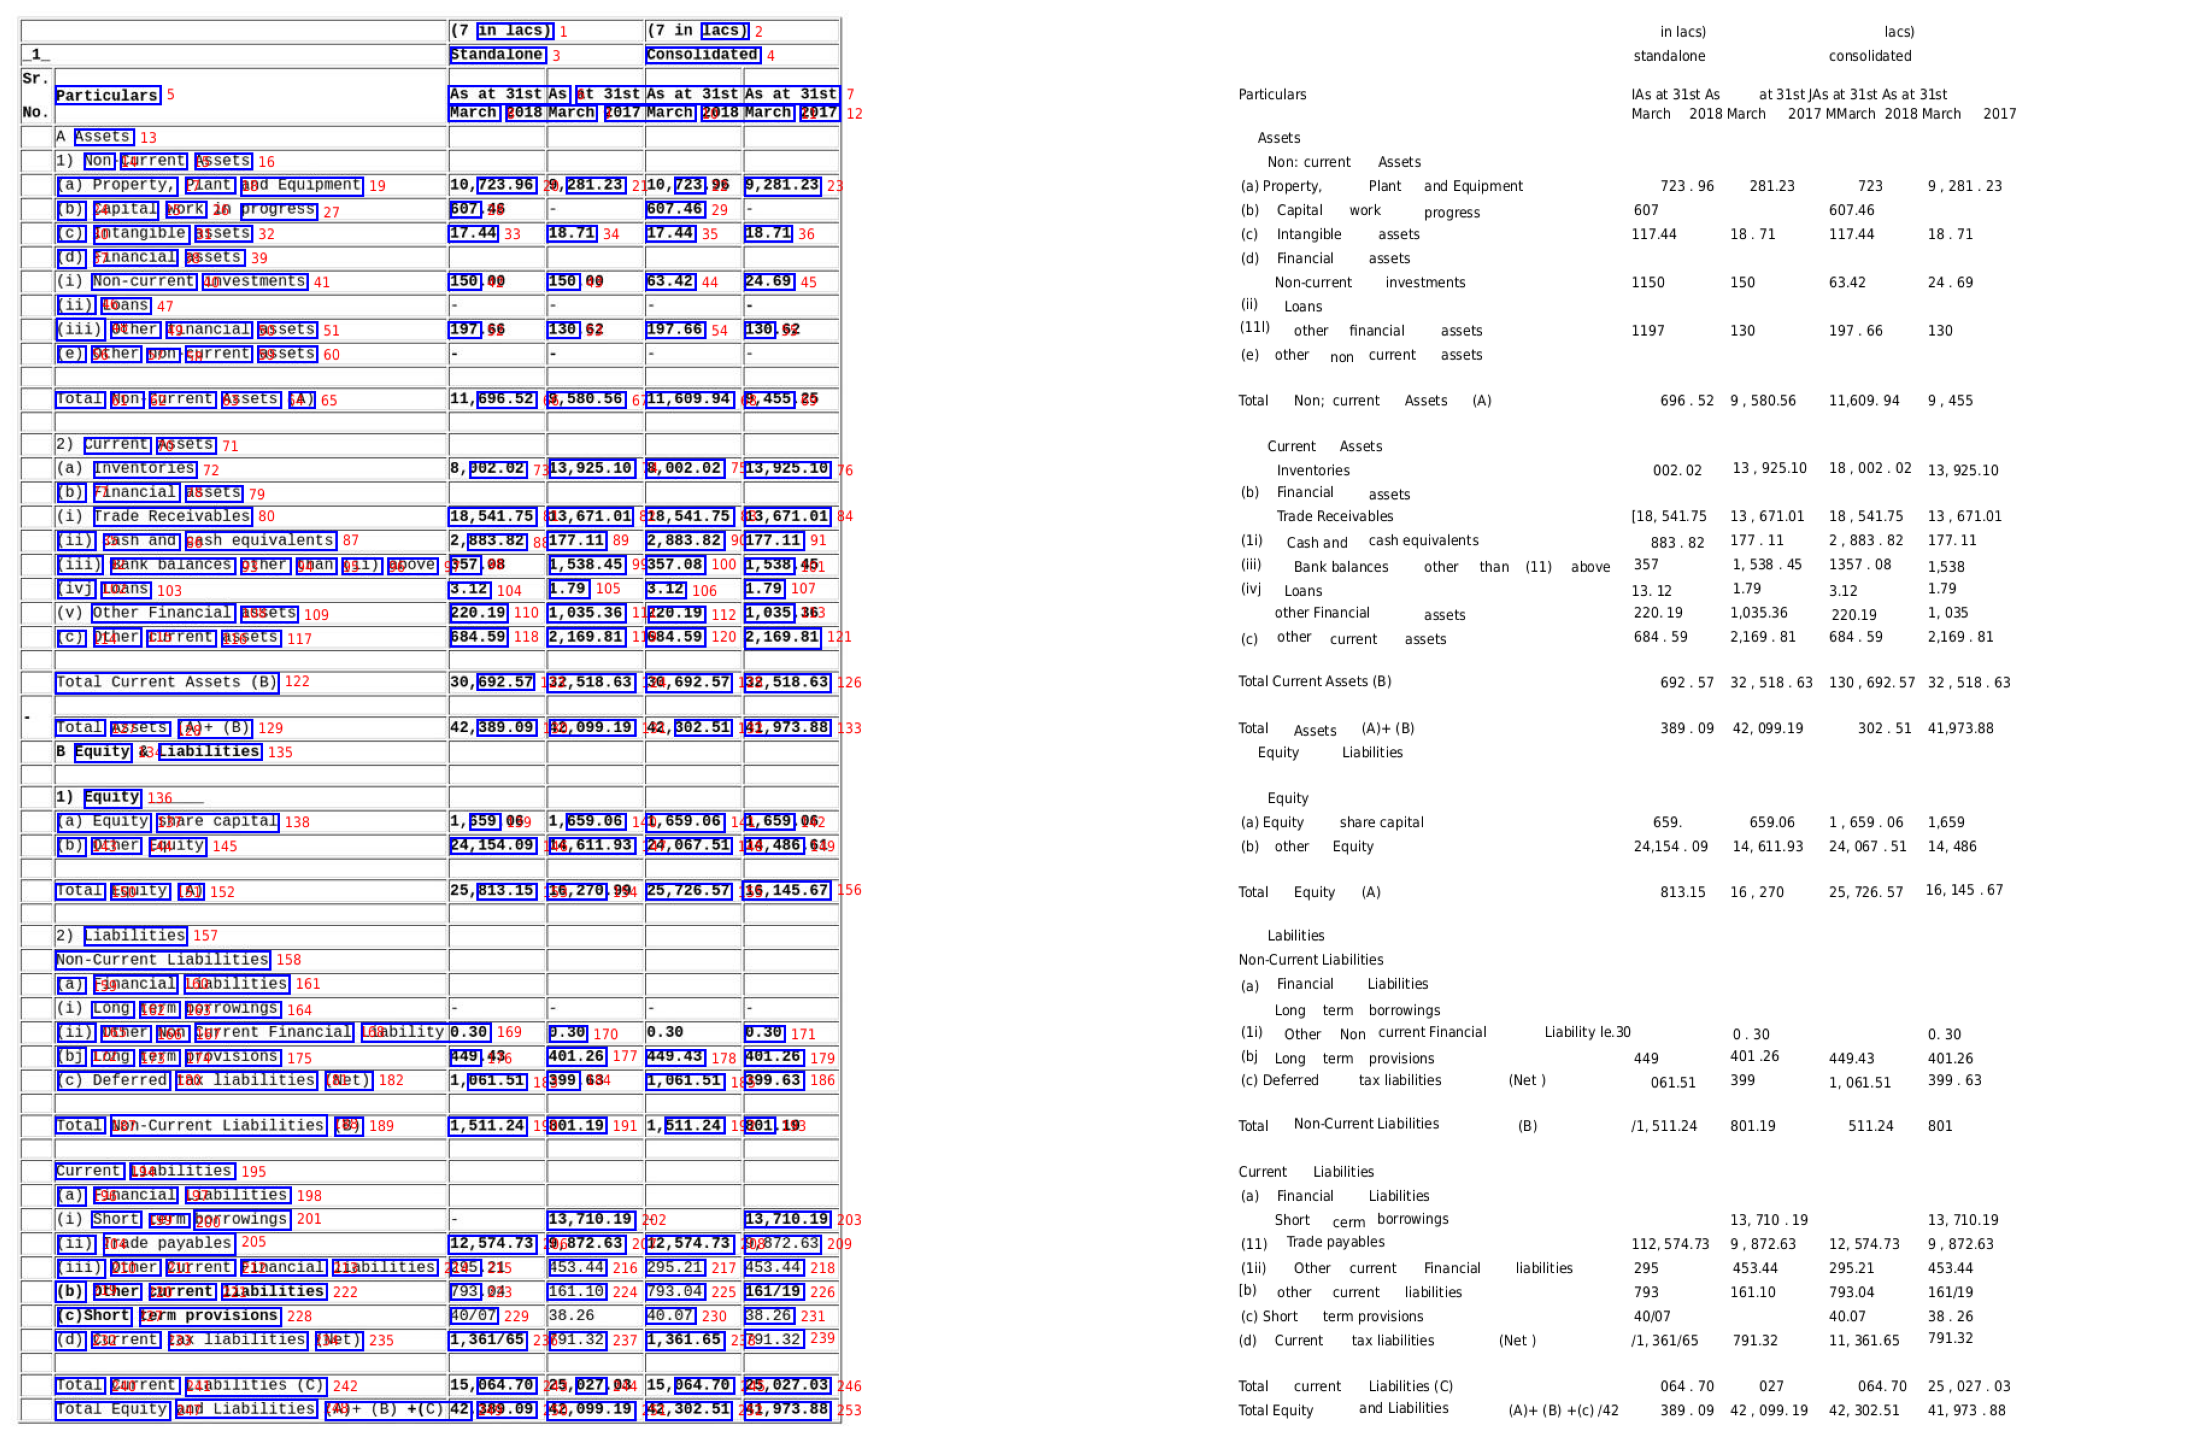

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 28))

left_image = Image.open(image_path).convert("RGB")
right_image = Image.new("RGB", left_image.size, (255, 255, 255))

left_draw = ImageDraw.Draw(left_image)
right_draw = ImageDraw.Draw(right_image)

for i, (bbox, word, confidence) in enumerate(ocr_result):
    box = create_bounding_box(bbox)

    left_draw.rectangle(box, outline="blue", width=2)
    left, top, right, bottom = box

    left_draw.text((right + 5, top), text=str(i + 1), fill="red", font=font)
    right_draw.text((left, top), text=word, fill="black", font=font)

ax1.imshow(left_image)
ax2.imshow(right_image)
ax1.axis("off");
ax2.axis("off");

In [26]:
for image_path in tqdm(image_paths):
    ocr_result = read_data.readtext(str(image_path), batch_size=16)

    ocr_page = []
    for bbox, word, confidence in ocr_result:
        ocr_page.append({
            "word": word, "bounding_box": create_bounding_box(bbox)
        })

    with image_path.with_suffix(".json").open("w") as f:
        json.dump(ocr_page, f)

100%|██████████| 2573/2573 [29:31<00:00,  1.45it/s]


In [27]:
!tar -cJf financial-documents-ocr.tar.xz "./images"

In [28]:
!gdown 1bQ4mFbVRUtOEJSe8b4hUYIcngSgfdldw

Downloading...
From (original): https://drive.google.com/uc?id=1bQ4mFbVRUtOEJSe8b4hUYIcngSgfdldw
From (redirected): https://drive.google.com/uc?id=1bQ4mFbVRUtOEJSe8b4hUYIcngSgfdldw&confirm=t&uuid=f7df8500-25ec-4b9a-8363-ec2c3ea5e03f
To: /content/financial-documents-ocr.tar.xz
100% 147M/147M [00:03<00:00, 47.6MB/s]


In [29]:
!tar -xf financial-documents-ocr.tar.xz

In [30]:
image_paths = sorted(list(Path("images").glob("*/*.jpg")))

In [31]:
feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=False)
tokenizer = LayoutLMv3TokenizerFast.from_pretrained("microsoft/layoutlmv3-base")
processor = LayoutLMv3Processor(feature_extractor, tokenizer)

/usr/local/lib/python3.10/dist-packages/transformers/models/layoutlmv3/feature_extraction_layoutlmv3.py:30: FutureWarning: The class LayoutLMv3FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv3ImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [33]:
image_path = image_paths[0]
image = Image.open(image_path).convert("RGB")
width, height = image.size
width_scale = 1000 / width
height_scale = 1000 / height

width_scale, height_scale

(1.221001221001221, 0.8368200836820083)

In [35]:
json_path = image_path.with_suffix(".json")
with json_path.open("r") as f:
    ocr_result = json.load(f)

def scale_bounding_box(box: List[int], width_scale : float = 1.0, height_scale : float = 1.0) -> List[int]:
    return [
        int(box[0] * width_scale),
        int(box[1] * height_scale),
        int(box[2] * width_scale),
        int(box[3] * height_scale)
    ]
words = []
boxes = []
for row in ocr_result:
    boxes.append(scale_bounding_box(row["bounding_box"], width_scale, height_scale))
    words.append(row["word"])


In [36]:
encoding = processor(
    image,
    words,
    boxes=boxes,
    max_length=512,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask', 'bbox', 'pixel_values'])

In [37]:
image_data = encoding["pixel_values"][0]
image_data.shape

torch.Size([3, 224, 224])

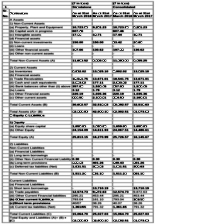

In [38]:
transform = T.ToPILImage()
transform(image_data)

In [39]:
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

### Model

In [56]:
model = LayoutLMv3ForSequenceClassification.from_pretrained("microsoft/layoutlmv3-base", num_labels=2)


Some weights of LayoutLMv3ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
model.config

LayoutLMv3Config {
  "_name_or_path": "microsoft/layoutlmv3-base",
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "coordinate_size": 128,
  "eos_token_id": 2,
  "has_relative_attention_bias": true,
  "has_spatial_attention_bias": true,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "input_size": 224,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_2d_position_embeddings": 1024,
  "max_position_embeddings": 514,
  "max_rel_2d_pos": 256,
  "max_rel_pos": 128,
  "model_type": "layoutlmv3",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "patch_size": 16,
  "rel_2d_pos_bins": 64,
  "rel_pos_bins": 32,
  "second_input_size": 112,
  "shape_size": 128,
  "text_embed": true,
  "torch_dtype": "float32",
  "transformers_version": "4.40.2",
  "type_vocab_size": 1,
  "visual_embed": true,
  "vocab_size": 50265
}

In [57]:
encoding = processor(
    image,
    words,
    boxes=boxes,
    max_length=512,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

outputs = model(**encoding)
outputs.logits

tensor([[ 0.0902, -0.2219]], grad_fn=<AddmmBackward0>)

In [58]:
train_images, test_images = train_test_split(image_paths, test_size=.2)

In [59]:
DOCUMENT_CLASSES = sorted(list(map(lambda p: p.name, Path("images").glob("*"))))
DOCUMENT_CLASSES

['balance_sheets', 'cash_flow', 'income_statement', 'notes', 'others']

In [61]:
# image_path = image_paths[0]
# DOCUMENT_CLASSES.index(image_path.parent.name)
# print(image_path)

images/balance_sheets/18320959_3.jpg


In [62]:
class DocumentClassificationDataset(Dataset):

    def __init__(self, image_paths, processor):
        self.image_paths = image_paths
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):

        image_path = self.image_paths[item]
        json_path = image_path.with_suffix(".json")
        with json_path.open("r") as f:
            ocr_result = json.load(f)

            with Image.open(image_path).convert("RGB") as image:

                width, height = image.size
                width_scale = 1000 / width
                height_scale = 1000 / height

                words = []
                boxes = []
                for row in ocr_result:
                    boxes.append(scale_bounding_box(row["bounding_box"], width_scale, height_scale))
                    words.append(row["word"])

                encoding = self.processor(
                    image,
                    words,
                    boxes=boxes,
                    max_length=512,
                    padding="max_length",
                    truncation=True,
                    return_tensors="pt"
                )

        label = DOCUMENT_CLASSES.index(image_path.parent.name)

        return dict(
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            bbox=encoding["bbox"].flatten(end_dim=1),
            pixel_values=encoding["pixel_values"].flatten(end_dim=1),
            labels=torch.tensor(label, dtype=torch.long)
        )


train_dataset = DocumentClassificationDataset(train_images, processor)
test_dataset = DocumentClassificationDataset(test_images, processor)

for item in train_dataset:
    print(item["bbox"].shape)
    print(item["pixel_values"].shape)
    print(item["labels"].shape)
    break

torch.Size([512, 4])
torch.Size([3, 224, 224])
torch.Size([])


In [63]:
train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2
)

class ModelModule(pl.LightningModule):
    def __init__(self, n_classes:int):
        super().__init__()
        self.model = LayoutLMv3ForSequenceClassification.from_pretrained(
            "microsoft/layoutlmv3-base",
            num_labels=n_classes
        )
        self.model.config.id2label = {k: v for k, v in enumerate(DOCUMENT_CLASSES)}
        self.model.config.label2id = {v: k for k, v in enumerate(DOCUMENT_CLASSES)}
        self.train_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=n_classes)

    def forward(self, input_ids, attention_mask, bbox, pixel_values, labels=None):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            bbox=bbox,
            pixel_values=pixel_values,
            labels=labels
        )

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        bbox = batch["bbox"]
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]
        output = self(input_ids, attention_mask, bbox, pixel_values, labels)
        self.log("train_loss", output.loss)
        self.log("train_acc", self.train_accuracy(output.logits, labels), on_step=True, on_epoch=True)
        return output.loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        bbox = batch["bbox"]
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]
        output = self(input_ids, attention_mask, bbox, pixel_values, labels)
        self.log("val_loss", output.loss)
        self.log("val_acc", self.val_accuracy(output.logits, labels), on_step=False, on_epoch=True)
        return output.loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.00001) #1e-5
        return optimizer


model_module = ModelModule(len(DOCUMENT_CLASSES))

Some weights of LayoutLMv3ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
model_checkpoint = ModelCheckpoint(
    filename="{epoch}-{step}-{val_loss:.4f}", save_last=True, save_top_k=3, monitor="val_loss", mode="min"
)

trainer = pl.Trainer(
    accelerator="gpu",
    precision=16,
    devices=1,
    max_epochs=5,
    callbacks=[
        model_checkpoint
    ],
)

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:563: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [65]:
trainer.fit(model_module, train_data_loader, test_data_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type                                | Params
-----------------------------------------------------------------------
0 | model          | LayoutLMv3ForSequenceClassification | 125 M 
1 | train_accuracy | MulticlassAccuracy                  | 0     
2 | val_accuracy   | MulticlassAccuracy                  | 0     
-----------------------------------------------------------------------
125 M     Trainable params
0         Non-trainable params
125 M     Total params
503.686   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


### **Evaluataion**

In [66]:
model_checkpoint.best_model_path

'/content/lightning_logs/version_0/checkpoints/epoch=4-step=1290-val_loss=0.1210.ckpt'

In [69]:
trained_model = ModelModule.load_from_checkpoint(
    model_checkpoint.best_model_path,
    n_classes=len(DOCUMENT_CLASSES),
    local_files_only=True
)

trained_model.model.save_pretrained(Path("best-model"))





Some weights of LayoutLMv3ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
notebook_login()

In [75]:
trained_model.model.push_to_hub("layoutlmv3-financial-document-classification")

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
model = LayoutLMv3ForSequenceClassification.from_pretrained("PawIEEE/layoutlmv3-financial-document-classification")
model = model.eval().to(DEVICE)

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

In [76]:
def predict_document_image(
    image_path: Path,
    model: LayoutLMv3ForSequenceClassification,
    processor: LayoutLMv3Processor):

    json_path = image_path.with_suffix(".json")
    with json_path.open("r") as f:
        ocr_result = json.load(f)

        with Image.open(image_path).convert("RGB") as image:

            width, height = image.size
            width_scale = 1000 / width
            height_scale = 1000 / height

            words = []
            boxes = []
            for row in ocr_result:
                boxes.append(
                    scale_bounding_box(
                        row["bounding_box"],
                        width_scale,
                        height_scale
                    )
                )
                words.append(row["word"])

            encoding = processor(
                image,
                words,
                boxes=boxes,
                max_length=512,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )

    with torch.inference_mode():
        output = model(
            input_ids=encoding["input_ids"].to(DEVICE),
            attention_mask=encoding["attention_mask"].to(DEVICE),
            bbox=encoding["bbox"].to(DEVICE),
            pixel_values=encoding["pixel_values"].to(DEVICE)
        )

    predicted_class = output.logits.argmax()
    return model.config.id2label[predicted_class.item()]

In [77]:
labels = []
predictions = []
for image_path in tqdm(test_images):
    labels.append(image_path.parent.name)
    predictions.append(predict_document_image(image_path, model, processor))

  0%|          | 0/515 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|██████████| 515/515 [00:46<00:00, 11.09it/s]


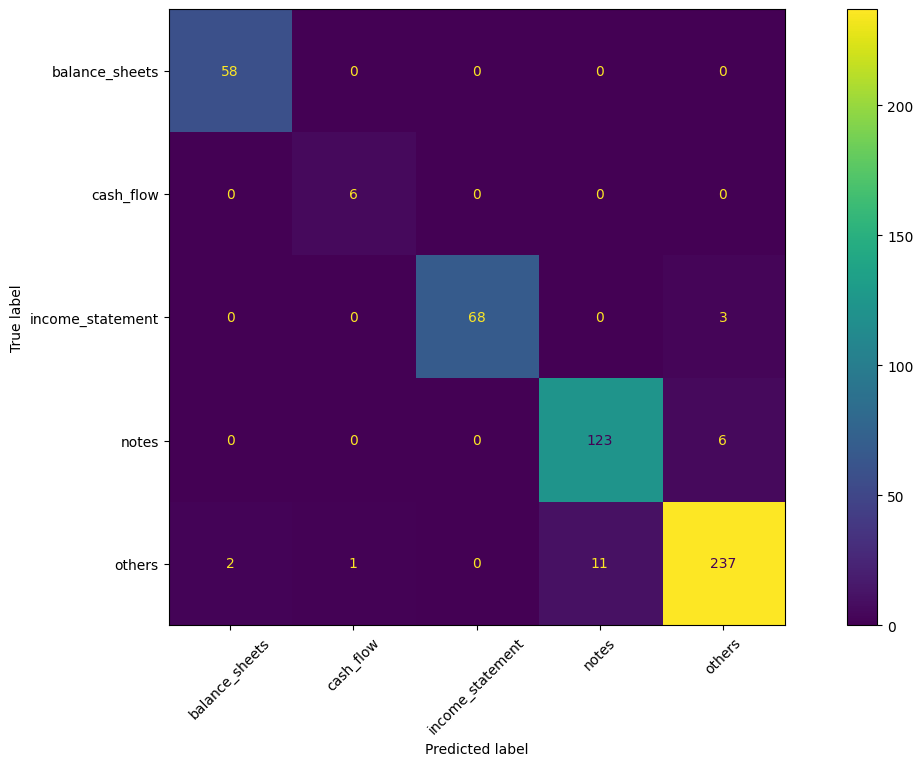

In [78]:
cm = confusion_matrix(labels, predictions, labels=DOCUMENT_CLASSES)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=DOCUMENT_CLASSES
)

cm_display.plot()
cm_display.ax_.set_xticklabels(DOCUMENT_CLASSES, rotation=45)
cm_display.figure_.set_size_inches(16, 8)

plt.show();